In [1]:
"""
Model II: Version I
Y[i,j,k,0] -> same loop
Y[i,j,k,1] -> next loop
Y[i,i,k,u] == 0
Y[i,j,k,1] == 0 if i<j
coupled with W variables and additional constraints on Y
"""

In [2]:
import numpy as np
from gurobipy import *
import pandas as pd
import time

In [3]:
#m.reset()
m = Model("target_inventory")

Academic license - for non-commercial use only


In [4]:
#demand = [20,12] #Demand rate per hour
#demand = [10,5]
demand = [5,2]
prod_rate = [28,23] #Production rate per hour
I_zero = [5,10] #Initial Inventory
#I_target_low = [500,200] #Target Inventory_lower
I_target_low = [500,200]
I_target_upper = [2000,500]
bcost = [10,2] #backorder cost
C = np.array([[10000,5],[4,10000]])
loops = 2
seq = [1,2]
T = 50
#define time - is added as variable


In [5]:
#range of products and loops
nprod = range(len(seq))
nloops = range(loops)
nmloops = range(loops-1)
LI = [0,1] #loop indicator -> zero for same, and 1 for next loop 

# Variable Declaration

In [6]:
#Create variables
y = m.addVars(nprod,nprod,nloops,LI, vtype = GRB.BINARY, name = "y") #to indicate switch from product i to product j
z = m.addVars(nprod,nloops, vtype = GRB.BINARY, name = "z") #to indicate if m/c has to be setup for i in loop k
x = m.addVars(nprod,nloops, vtype = GRB.INTEGER, lb = 0, name = "x") #production time of product i in loop k
inv_k = m.addVars(nprod,nloops, vtype = GRB.CONTINUOUS, lb = -10000000, name = "inv_k") #inventory at the beginning of loop k
#rows are products and columns are loops
L = m.addVars(nprod,nloops, vtype = GRB.CONTINUOUS,lb = -100000000, name = "L") # maximum backlog
#T = m.addVar(vtype=GRB.CONTINUOUS, name = "total_time")
W = m.addVars(nloops, vtype = GRB.BINARY, name = "W")#"Continuous_loop_check")
I_last = m.addVars(nprod, vtype = GRB.CONTINUOUS, name = "I_final")

#objective is to minimize the total backlog and minimize the production time
m.modelSense = GRB.MINIMIZE

# Objective Function

In [7]:
m.setObjective(sum(bcost[i]*L[i,k] for i in nprod for k in nloops), GRB.MINIMIZE)  #+T removed
#is this minimize for each loop or over all loops? Check this for the bi*Li
#m.setObjective(sum(C[i,j]*y[i,j,k,u] for i in nprod for j in nprod for k in nloops for u in LPI), GRB.MINIMIZE)
    

# Constraints

In [8]:
#Constraints for backlog Li

#backlog should be greater than 0
m.addConstrs(L[i,k] >= 0 for i in nprod for k in nloops) 

#backlog should be greater than the negative of negative inventory - so push it to positive
m.addConstrs(L[i,k] >= -inv_k[i, k] for i in nprod for k in nloops);
    



In [9]:
#constraint for initial inventory at beginning of first loop
#add changeover time
m.addConstrs(inv_k[i,0] == I_zero[i] 
             - demand[i] *sum(x[j,0] for j in nprod  if j < i)
             - demand[i]*sum(C[l,j]*y[l,j,0,0] for j in nprod for l in nprod if l<j if j<=i) for i in nprod); #add changeover time

In [10]:
#inventory constraint for every loop for i in nprod  
#add changeover time
#(loops - 1) is to prevent from going out of range
m.addConstrs(inv_k[i, k+1] == inv_k[i,k] + x[i,k]*(prod_rate[i] - demand[i]) - 
             demand[i]*(((sum(C[l,j]*y[l,j,k,0] for l in nprod if l>=i for j in nprod if j>l) 
                             + sum(C[l,j]*y[l,j,k,1] for j in nprod if j<=i for l in nprod if l>=i))) 
                        + sum(C[l,j]*y[l,j,k+1,0] for j in nprod if i>=j for l in nprod  if j>l))
             for i in nprod for k in range(loops-1));
             
                    # demand[i]*sum(x[j, k] for j in nprod if j>i) - demand[i]*sum(x[j, k+1] for j in nprod if j<i) 
                    # - demand[i]*sum(C[i,j]*y[i,j,k,0] for j in nprod if j>i) 
                    # - demand[i]*sum(C[i,j]*y[i,j,k,1] for j in nprod if j<i) for i in nprod for k in range(loops - 1));


# FIX THE FORMATTING





In [11]:
#constraint for target inventory - lower bound
k_last = loops - 1
m.addConstrs(I_target_low[i] <= inv_k[i,k_last] +  x[i,k_last]*(prod_rate[i] - demand[i])
             - demand[i] * sum(x[j,k_last] for j in nprod if j > i) 
             - demand[i]*sum(C[l,j]*y[l,j,k_last,0] for l in nprod if l>=i for j in nprod if j>l) for i in nprod);

In [12]:
#constraint for target inventory - upper bound
k_last = loops - 1
m.addConstrs(I_target_upper[i] >= inv_k[i,k_last] +  x[i,k_last]*(prod_rate[i] - demand[i])
             - demand[i] * sum(x[j,k_last] for j in nprod if j > i) 
             - demand[i]*sum(C[l,j]*y[l,j,k_last,0] for l in nprod if l>=i for j in nprod if j>l) for i in nprod);

In [13]:
m.addConstrs(I_last[i] == inv_k[i,k_last] +  x[i,k_last]*(prod_rate[i] - demand[i])
             - demand[i] * sum(x[j,k_last] for j in nprod if j > i) 
             - demand[i]*sum(C[l,j]*y[l,j,k_last,0] for l in nprod if l>=i for j in nprod if j>l) for i in nprod);

In [14]:
#constraint on total time including production and changeover
#m.addConstr(T>=sum(x[i,k] for i in nprod for k in nloops)+ sum(C[i,j]*y[i,j,k,0] for i in nprod for j in nprod for k in nloops));

In [15]:
m.addConstr(T >= sum(x[i,k] for i in nprod for k in nloops) + sum(C[i,j]*y[i,j,k,u] for i in nprod for j in nprod for k in nloops for u in LI));

In [16]:
#constraint to check whether i is being produced or not
#M_large = 200
#for k in nloops:
 #   m.addConstrs(z[i,k] >= x[i,k]/M_large for i in nprod) 
#Does this check for exact 0? If not, then adjust the constant
#forcing divisor to be a constant - will work if T is not added to the objective function - because if constant then
#no sense of adding it to the objective function

In [17]:
m.addConstrs(z[i,k] >= x[i,k]/T for i in nprod for k in nloops) 

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>}

In [18]:
#constraint to set the values of yij for all products where j > i IN THE SAME LOOP

m.addConstrs(y[i,j,k,0] >= z[i,k] + z[j,k] - 1 - sum(z[u,k] for u in range(i+1,j-1) if j>i) for j in nprod for i in nprod for k in nloops if j>i);

    

In [19]:
#constraint to set the values of yij for all products where j < i IN DIFFERENT LOOPS

m.addConstrs(y[i,j,k,1] >= z[i,k] + z[j,k+1] - 1 - sum(z[u,k] for u in nprod if u>i) - sum(z[v,k+1] for v in nprod if v<j)
                for j in nprod for i in nprod for k in range(loops-1));

In [20]:
#Sharat -> 5/14/19

m.addConstrs(y[i,j,k,1] == 0 for i in nprod for j in nprod if j>i for k in range(loops-1) );

#Observation: Necessary constraint otherwise y[0,1,0,0] and y[0,1,0,1] are being set to 1, which cannot happen. 

In [21]:
#Sharat -> 5/12/19, This constraint will restrict the changeover between two products i & j to be in the same loop if j>i.

#m.addConstrs(y[i,j,k,0] + y[i,j,k,1] <= 1 for i in nprod for j in nprod if j>i for k in nloops); 
# OR Condition with below const
#m.addConstrs(y[i,j,k,0] >= y[i,j,k,1] for i in nprod for j in nprod if j>i for k in nloops); 
# Supports and linked to preceding constraint

In [22]:
#Sharat -> 5/12/19, Constraint to avoid changeover between the same product between different loops

m.addConstrs(y[i,i,k,0] == 0 for i in nprod for k in nloops );
m.addConstrs(y[i,i,k,1] == 0 for i in nprod for k in range(loops-1) );

# INFEASIBILITY FOR 7 LOOPS was due to the above two contraints

m.addConstrs(x[i,k] >= z[i,k]*0.1 for i in nprod for k in nloops);

#Observation: Necessary constraints without which there could be changeover between same products

In [23]:
#constraint to check that loop is not skipped
m.addConstr(W[0] == 1);
m.addConstrs(W[k] >= z[i,k] for i in nprod for k in nloops);
m.addConstrs(W[k] <= sum(z[i,k] for i in nprod) for k in nloops);
m.addConstrs(W[k+1] <= W[k] for k in range(loops-1));

# Solving the model

In [24]:
start_time = time.time()
m.optimize();
end_time = time.time()


Optimize a model with 48 rows, 36 columns and 130 nonzeros
Variable types: 10 continuous, 26 integer (22 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+04]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+08]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 150.0000000
Presolve removed 30 rows and 22 columns
Presolve time: 0.00s
Presolved: 18 rows, 14 columns, 56 nonzeros
Variable types: 0 continuous, 14 integer (6 binary)

Root relaxation: objective 8.000000e+00, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.00000    0    3  150.00000    8.00000  94.7%     -    0s
H    0     0                       8.0000000    8.00000  0.00%     -    0s

Explored 1 nodes (5 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 8 150 

Optimal solution fou

In [25]:
sol = []
for v in m.getVars():
    sol.append((v.Varname, v.X))
    print("%s %f" % (v.Varname, v.X))
    
#m.write("Backlog_minimization.sol");

y[0,0,0,0] 0.000000
y[0,0,0,1] 0.000000
y[0,0,1,0] 0.000000
y[0,0,1,1] 0.000000
y[0,1,0,0] 1.000000
y[0,1,0,1] 0.000000
y[0,1,1,0] 1.000000
y[0,1,1,1] 0.000000
y[1,0,0,0] 0.000000
y[1,0,0,1] 1.000000
y[1,0,1,0] 0.000000
y[1,0,1,1] 0.000000
y[1,1,0,0] 0.000000
y[1,1,0,1] 0.000000
y[1,1,1,0] 0.000000
y[1,1,1,1] 0.000000
z[0,0] 1.000000
z[0,1] 1.000000
z[1,0] 1.000000
z[1,1] 1.000000
x[0,0] 2.000000
x[0,1] 23.000000
x[1,0] 10.000000
x[1,1] 1.000000
inv_k[0,0] 5.000000
inv_k[0,1] 6.000000
inv_k[1,0] -4.000000
inv_k[1,1] 188.000000
L[0,0] 0.000000
L[0,1] -0.000000
L[1,0] 4.000000
L[1,1] 0.000000
W[0] 1.000000
W[1] 1.000000
I_final[0] 505.000000
I_final[1] 209.000000


In [26]:
print("time taken = "+str(end_time-start_time))

time taken = 0.05784440040588379


In [27]:
#Added by Sharat on 10/18/19 to retrieve only the activated changeover binary variable.

#Warning: Need to fix the code to account the first job processing time. 
#It's right now missing proc time of job 0 in loop 0 for this example.

solx=[]
solx= m.getAttr('x', x)   
soly=[]
soly= m.getAttr('x', y)   
solz=[]
solz= m.getAttr('x', z)   

Final_soly =[] 
Sequence = []
proctime = []

for k in nloops:
    for i in nprod:
        for j in nprod:
            for L in range(0,2):
                if soly[i,j,k,L] == 1:
                    Final_soly.append([i,j,k,L])
                    Sequence.append([j])
                    proctime.append([solx[j,k]])
                    
Final_soly

#Sequence
#proctime
#print("time taken = "+str(end_time-start_time))

[[0, 1, 0, 0], [1, 0, 0, 1], [0, 1, 1, 0]]

In [28]:
df = pd.DataFrame(sol)
df.to_csv("Solutions_formulation_new.csv", header = ["Name","Value"], index = False)

In [29]:
inv_val = [[prod, round(x[prod,loop].X,2),round(inv_k[prod,loop].X,2)] for prod in nprod for loop in nloops]
inv_val = np.array(inv_val)

In [30]:
inv_val

array([[  0.,   2.,   5.],
       [  0.,  23.,   6.],
       [  1.,  10.,  -4.],
       [  1.,   1., 188.]])

In [31]:
import matplotlib.pyplot as plt

2.0 5.0
23.0 6.0


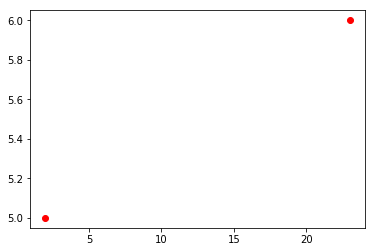

In [32]:
for item in range(len(inv_val)):
    if inv_val[item,0] == 0:
        print(inv_val[item,1], inv_val[item,2])
        plt.plot(inv_val[item,1], inv_val[item,2], 'ro')
plt.show()

In [33]:
#Added by Sharat on 10/18/19 to retrieve only the activated changeover binary variable.

#Warning: Need to fix the code to account the first job processing time. 
#It's right now missing proc time of job 0 in loop 0 for this example.

solx=[]
solx= m.getAttr('x', x)   
soly=[]
soly= m.getAttr('x', y)   
solz=[]
solz= m.getAttr('x', z)   

Final_soly =[] 
Sequence = []
proctime = []

for k in nloops:
    for i in nprod:
        for j in nprod:
            for L in range(0,2):
                if soly[i,j,k,L] == 1:
                    Final_soly.append([i,j,k,L])
                    Sequence.append([j])
                    proctime.append([solx[j,k]])
                    
Final_soly

#Sequence
#proctime
#print("time taken = "+str(end_time-start_time))

[[0, 1, 0, 0], [1, 0, 0, 1], [0, 1, 1, 0]]